# Modélisation 

### Import des modules 

In [26]:
import pandas as pd
import numpy as np
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


### Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

Prérequis 

S'être familiarisé avec le jeu de données via l'analyse exploratoire.
Avoir compris ce qu'est le feature engineering en regardant les chapitres indiqués en ressources. 
Résultat attendu  

Le notebook template avec la partie "Feature Engineering” complétée.
Recommandations  

Nous vous déconseillons fortement d'utiliser des outils comme ChatGPT pour cette section. D'abord, parce que des erreurs se glissent dans les codes générés en feature engineering souvent d'une manière assez subtile et qu’en tant que débutants, vous ne les  détecterez pas. Par contre, l'évaluateur pourra les voir. Ensuite, car cette compétence ne s'apprend pas autrement que par la pratique, ce n'est donc pas dans votre intérêt de l'automatiser à ce stade de votre apprentissage. 

Si le code de l’analyse exploratoire est long, ne pas hésiter à créer un second notebook pour l’alléger.  
Essayer de couvrir, dans la création des features, plusieurs catégories d'informations du jeu de données (localisation, temporalité, structure du bâtiment, etc.)
Voici quelques pistes de réflexion pour le feature engineering:
Il peut être intéressant d'indiquer à un modèle si un bâtiment a plusieurs types d'usages via des features binaires ou des proportions.
Pour certaines features catégorielles à haute cardinalité, il peut être intéressant de créer des tranches de valeurs pour les compresser.
Les valeurs des sources d'énergies (gaz, électricité) ne peuvent pas être utilisées, car cela créerait du data leakage, mais rien ne nous empêche de créer des features indiquant quels types de sources d'énergie existent au sein de chaque bâtiment (ce sont des informations structurelles des bâtiments, indépendantes de l'intensité de la consommation en énergie).
Points de vigilance  

Attention au data leakage : on ne peut pas donner à un modèle de ML des features qui ne peuvent être calculées qu'en connaissant la consommation d'énergie, alors que c'est cette quantité qu'il faut prédire.
Se fixer à l'avance un certain nombre d'heures à ne pas dépasser sur cette partie. En effet, on pourrait infiniment réfléchir à rajouter de plus en plus de features avant de réaliser un 1er modèle. L’objectif ici est surtout de comprendre par la pratique l’importance du feature engineering. Vous ne serez pas jugé sur la performance de votre modèle sur ce projet.
Ressources 

La section Feature Engineering du chapitre Transformez les variables pour faciliter l'apprentissage du modèle du cours d'initiation.
La section Feature Engineering de ce cours avancé qui couvre quelques techniques classiques et le data leakage.

Crée une copie propre du jeu de données pour les prochaines étapes.

Assainit le typage des colonnes numériques (conversion explicite).

Prépare le DataFrame pour des opérations mathématiques, statistiques ou de machine learning sans erreurs de type.

In [47]:
# Point de départ : on repart d'une copie de df (sortie EDA)
df_model = pd.read_csv("C:\\Users\\matde\\Documents\\OpenClassrooms\\Projet_6\\df_model.csv")
df_fe = df_model.copy()

# Sécurisation du typage numérique pour éviter surprises plus tard
to_num = [
    "PropertyGFATotal", "PropertyGFABuildings", "PropertyGFAParking",
    "NumberofFloors", "NumberofBuildings", "YearBuilt", "DataYear",
    "Latitude", "Longitude", "LargestPropertyUseTypeGFA",
    "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"
]
for c in to_num:
    if c in df_fe.columns:
        df_fe[c] = pd.to_numeric(df_fe[c], errors="coerce")

print("df_fe shape:", df_fe.shape)

df_fe shape: (1534, 20)


Calcule l’âge du bâtiment à partir de l’année des données (DataYear) et de l’année de construction (YearBuilt).  
Intérêt :

Variable temporelle souvent très explicative (vieux bâtiments = moins efficaces énergétiquement, p. ex.).

Permet de comparer des bâtiments de différentes générations.

In [48]:
if {"DataYear","YearBuilt"}.issubset(df_fe.columns):
    df_fe["BuildingAge"] = df_fe["DataYear"] - df_fe["YearBuilt"]

Calcule la proportion de surface dédiée au parking par rapport à la surface totale (GFA = Gross Floor Area).  
Avant cela, on évite les divisions par zéro en remplaçant les valeurs ≤ 0 par NaN.  
Intérêt :

Donne une idée de la typologie du site (bureaux urbains ≠ centres commerciaux avec grands parkings).

Peut être utile pour estimer la consommation énergétique (parking chauffé, ventilé, etc.).

In [49]:
if {"PropertyGFAParking","PropertyGFATotal"}.issubset(df_fe.columns):
    df_fe.loc[df_fe["PropertyGFATotal"] <= 0, "PropertyGFATotal"] = np.nan
    df_fe["ParkingRatio"] = df_fe["PropertyGFAParking"] / df_fe["PropertyGFATotal"]

Surface moyenne par étage
Calcule la surface moyenne d’un étage.  
Intérêt :

Donne une idée de la compacité verticale.

Utile pour repérer des erreurs de saisie (par ex. 1 étage pour 50 000 m² → suspect).

In [50]:
if {"PropertyGFABuildings","NumberofFloors"}.issubset(df_fe.columns):
    floors = df_fe["NumberofFloors"].replace(0, np.nan)
    df_fe["AreaPerFloor"] = df_fe["PropertyGFABuildings"] / floors

Densité de bâtiments  
Calcule le nombre de bâtiments par unité de surface totale.
ntérêt :

Reflète la fragmentation du site (plusieurs petits bâtiments vs un grand).

Peut influencer la logistique, les coûts, la consommation énergétique, etc.

In [51]:
if {"NumberofBuildings","PropertyGFATotal"}.issubset(df_fe.columns):
    df_fe["BuildingDensity"] = df_fe["NumberofBuildings"] / df_fe["PropertyGFATotal"]


Clustering spatial avec K-Means  
K-Means regroupe les points (ici les bâtiments) en k zones géographiques homogènes, en fonction de leur proximité en latitude/longitude.  
Plus réaliste : regroupe les bâtiments où ils se trouvent réellement.

Flexible : on choisit n_clusters selon ton échantillon (par ex. 5, 10, 20).

Reproductible : les mêmes clusters reviennent avec le même random_state.

In [52]:
from sklearn.cluster import KMeans

if {"Latitude", "Longitude"}.issubset(df_fe.columns):
    coords = df_fe[["Latitude", "Longitude"]].dropna()
    kmeans = KMeans(n_clusters=10, random_state=42)
    clusters = kmeans.fit_predict(coords)
    df_fe.loc[coords.index, "GeoCluster"] = clusters

C:\Users\matde\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


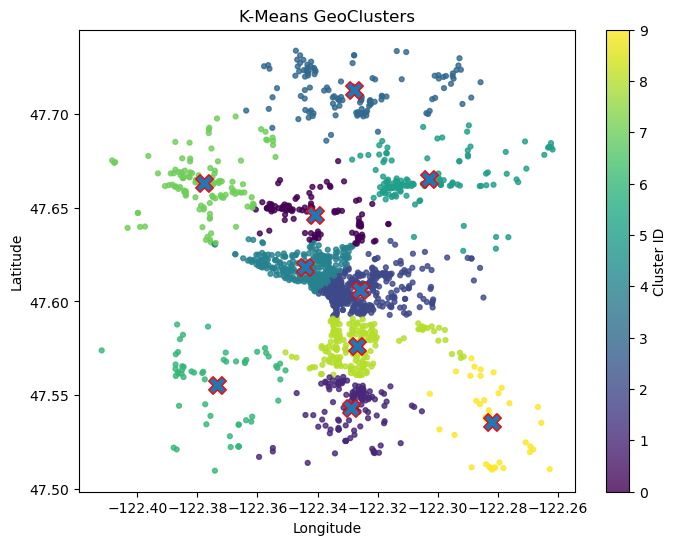

In [53]:
import numpy as np
import matplotlib.pyplot as plt

assert {"Latitude","Longitude","GeoCluster"}.issubset(df_fe.columns)

# Nuage de points coloré par cluster
plt.figure(figsize=(8,6))
sc = plt.scatter(
    df_fe["Longitude"], df_fe["Latitude"],
    c=df_fe["GeoCluster"], s=12, alpha=0.8
)
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("K-Means GeoClusters")
plt.colorbar(sc, label="Cluster ID")

# Centroides si tu as l'objet kmeans (optionnel)
try:
    centers = kmeans.cluster_centers_   # shape: (k, 2) -> [lat, lon]
    plt.scatter(centers[:,1], centers[:,0], marker="X", s=160, edgecolor="r")
except Exception:
    pass

plt.show()


Caractériser la configuration énergétique du bâtiment, sans inclure les consommations elles-mêmes.
Intérêt

Ces variables permettent au modèle :

de différencier les types d’installations énergétiques (ex. tout électrique vs mix gaz/élec),

de mieux expliquer les différences de performance énergétique,

sans risque de fuite sur la variable cible.

In [54]:
if "Electricity(kBtu)" in df_fe.columns:
    df_fe["UsesElectricity"] = df_fe["Electricity(kBtu)"].notna().astype(int)

if "NaturalGas(kBtu)" in df_fe.columns:
    df_fe["UsesNaturalGas"] = df_fe["NaturalGas(kBtu)"].notna().astype(int)

if "SteamUse(kBtu)" in df_fe.columns:
    df_fe["UsesSteam"] = df_fe["SteamUse(kBtu)"].notna().astype(int)

Encodages légers & préparation des colonnes

In [55]:
# ===== Encodages légers =====

# Catégories principales : remplir les NA par une modalité explicite
if "EPAPropertyType" in df_fe.columns:
    df_fe["EPAPropertyType"] = df_fe["EPAPropertyType"].fillna("Unknown")

if "LargestPropertyUseType" in df_fe.columns:
    df_fe["LargestPropertyUseType"] = df_fe["LargestPropertyUseType"].fillna("Unknown")

# Prévisualisation rapide des nouvelles colonnes
created_cols = ["BuildingAge","ParkingRatio","AreaPerFloor","BuildingDensity",
                "HasMultipleUses","LargestUseShare","SecondUseShare","ThirdUseShare",
                "LatBin","LonBin","GeoCluster","UsesElectricity","UsesNaturalGas","UsesSteam"]
created_cols = [c for c in created_cols if c in df_fe.columns]
print("Nouvelles features créées:", created_cols)
display(df_fe[created_cols].head())


Nouvelles features créées: ['BuildingAge', 'ParkingRatio', 'BuildingDensity', 'GeoCluster']


,BuildingAge,ParkingRatio,BuildingDensity,GeoCluster
0,89,0.000000,0.000011,4.0
1,20,0.145453,0.000010,2.0
2,47,0.205748,0.000001,4.0
3,90,0.000000,0.000016,4.0
4,36,0.353115,0.000006,4.0


définit proprement le jeu de features pour la modélisation tout en évitant le data leakage.

In [56]:
print(df_fe.columns.tolist())

['PropertyGFATotal', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'NumberofBuildings', 'NumberofFloors', 'BuildingAge', 'PrimaryPropertyType', 'LargestPropertyUseType', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'ParkingRatio', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'SiteEnergyUse(kBtu)_log', 'TotalGHGEmissions_log', 'PropertyGFATotal_log', 'PropertyGFABuilding(s)_log', 'PropertyGFAParking_log', 'BuildingDensity', 'GeoCluster']


In [57]:
# ===== Liste finale de features pour la modélisation (sans leakage) =====

target = "SiteEnergyUse(kBtu)"

# Colonnes catégorielles candidates (on fera OneHot dans le pipeline)
cat_features = [c for c in [
    "EPAPropertyType", "LargestPropertyUseType",
    "Neighborhood", "ZipCode", "GeoCluster"
] if c in df_fe.columns]

# Colonnes numériques candidates
num_features = [c for c in [
    "PropertyGFATotal", "PropertyGFABuildings", "PropertyGFAParking",
    "NumberofBuildings", "NumberofFloors",
    "BuildingAge", "ParkingRatio", "AreaPerFloor", "BuildingDensity",
    "LargestUseShare", "SecondUseShare", "ThirdUseShare",
    "Latitude", "Longitude",
    # Binnings (traités comme numériques ordinals ici, ou cat si tu préfères)
    "LatBin", "LonBin",
    # Indicateurs d'énergie (binaires)
    "UsesElectricity", "UsesNaturalGas", "UsesSteam"
] if c in df_fe.columns]

# Vérification anti-leakage : aucune des colonnes interdites ne doit apparaître
forbidden = {
    "SiteEnergyUse(kBtu)", "SiteEUIWN(kBtu/sf)", "SiteEUI(kBtu/sf)",
    "SourceEUIWN(kBtu/sf)", "SourceEUI(kBtu/sf)",
    "Electricity(kWh)", "Electricity(kBtu)", "NaturalGas(therms)", "NaturalGas(kBtu)",
    "SteamUse(kBtu)", "ENERGYSTARScore", "TotalGHGEmissions", "GHGEmissionsIntensity",
    "ComplianceStatus", "ComplianceIssue", "Demolished"
}
present_forbidden = sorted(set(df_fe.columns) & forbidden)
assert not any(f in (num_features + cat_features) for f in present_forbidden), \
    f"⚠️ Leakage: {present_forbidden} ne doivent pas être dans les features."

# Construction X, y
features_finales = num_features + cat_features
X = df_fe[features_finales].copy()
y = df_fe[target].copy()

print("X shape:", X.shape, "| y shape:", y.shape)
print("Num features:", len(num_features), "| Cat features:", len(cat_features))


X shape: (1534, 12) | y shape: (1534,)
Num features: 9 | Cat features: 3


### Synthèse — Feature Engineering

- **Structure** : `BuildingAge`, `ParkingRatio`, `AreaPerFloor`, `BuildingDensity`.
- **Usage** : `HasMultipleUses`, `LargestUseShare`, `SecondUseShare`, `ThirdUseShare`.
- **Localisation** : `LatBin`, `LonBin`, `GeoCluster` (+ `Neighborhood`/`ZipCode` si utile).
- **Énergie (sans leakage)** : `UsesElectricity`, `UsesNaturalGas`, `UsesSteam`.

👉 Aucune variable de **consommation** ou **émissions** n’a été utilisée comme feature.  
👉 Les variables catégorielles seront encodées **dans le pipeline de modélisation** (OneHotEncoder).  
👉 Prochaine étape : **Pipeline scikit-learn** (imputation, OneHot, scaling) + tests de modèles.


### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation.
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne.

In [ ]:
# CODE PREPARATION DES FEATURES

### Comparaison de différents modèles supervisés

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

1) Imports + split train/test (reproductible)

In [58]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 1) Définis TA cible ici
TARGET = "SiteEnergyUse(kBtu)"  # <-- adapte si besoin

# 2) Sépare les features (X) et la cible (y)
X = df_fe.drop(columns=[TARGET]).copy()
y = df_fe[TARGET].copy()

# 3) Split apprentissage/test (20% test), reproductible
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("Shapes -> X_train:", X_train.shape, "X_test:", X_test.shape)

Shapes -> X_train: (1227, 21) X_test: (307, 21)


2) Préprocesseur commun (imputation + encodage + scaling)

In [59]:
# Colonnes numériques / catégorielles (détectées automatiquement)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# 1) Numérique : remplace NA par la médiane + standardise l'échelle
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())  # met les colonnes à la même échelle
])

# 2) Catégoriel : remplace NA par la modalité la + fréquente + OneHotEncode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# 3) Assemble dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

preprocessor


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


3) Évaluateur générique (CV + train + test)

In [60]:
# Cross-validation 5-fold (même folds pour tous les modèles)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Scoring : on calcule R2, MAE et MSE (on convertira MSE -> RMSE)
scoring = {
    "r2": "r2",
    "mae": "neg_mean_absolute_error",
    "mse": "neg_mean_squared_error"
}

def evaluate_pipeline(name, pipeline, X_train, y_train, X_test, y_test):
    """
    - Fait une validation croisée sur le train (CV)
    - Refit sur TOUT le train
    - Calcule les métriques sur le train (pour diagnostic overfit) et sur le test
    - Retourne un dict avec tous les scores
    """
    # 1) CV sur train
    cv_res = cross_validate(
        pipeline, X_train, y_train,
        cv=cv, scoring=scoring,
        return_train_score=False, n_jobs=-1
    )
    cv_r2   = np.mean(cv_res["test_r2"])
    cv_mae  = -np.mean(cv_res["test_mae"])                 # repasse en positif
    cv_rmse = np.mean(np.sqrt(-cv_res["test_mse"]))        # racine du MSE

    # 2) Fit final sur TOUT le train
    pipeline.fit(X_train, y_train)

    # 3) Prédictions train/test
    y_pred_tr = pipeline.predict(X_train)
    y_pred_te = pipeline.predict(X_test)

    # 4) Métriques train/test
    out = {
        "model": name,
        "cv_r2_mean":   cv_r2,
        "cv_mae_mean":  cv_mae,
        "cv_rmse_mean": cv_rmse,
        "train_r2":  r2_score(y_train, y_pred_tr),
        "train_mae": mean_absolute_error(y_train, y_pred_tr),
        "train_rmse": np.sqrt(mean_squared_error(y_train, y_pred_tr)),
        "test_r2":   r2_score(y_test, y_pred_te),
        "test_mae":  mean_absolute_error(y_test, y_pred_te),
        "test_rmse": np.sqrt(mean_squared_error(y_test, y_pred_te)),
    }
    return out



4) Construire les pipelines de modèles

In [61]:
from sklearn.compose import TransformedTargetRegressor
import numpy as np

def with_log_target(estimator):
    """Enveloppe un estimateur pour apprendre sur log1p(y) et prédire dans l'échelle originale."""
    return TransformedTargetRegressor(
        regressor=estimator,
        func=np.log1p,        # y -> log(1+y)
        inverse_func=np.expm1 # inverse -> exp(y)-1
    )

# Pipelines "simples"
pipe_linear = Pipeline([("prepro", preprocessor), ("model", LinearRegression())])
pipe_ridge  = Pipeline([("prepro", preprocessor), ("model", Ridge())])
pipe_lasso  = Pipeline([("prepro", preprocessor), ("model", Lasso(max_iter=100_000))])
pipe_gb     = Pipeline([("prepro", preprocessor), ("model", GradientBoostingRegressor(random_state=42))])
pipe_rf     = Pipeline([("prepro", preprocessor), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))])

# Pipelines "log-cible"
pipe_ridge_log = Pipeline([("prepro", preprocessor), ("model", with_log_target(Ridge()))])
pipe_lasso_log = Pipeline([("prepro", preprocessor), ("model", with_log_target(Lasso(max_iter=100_000)))])
pipe_gb_log    = Pipeline([("prepro", preprocessor), ("model", with_log_target(GradientBoostingRegressor(random_state=42)))])
pipe_rf_log    = Pipeline([("prepro", preprocessor), ("model", with_log_target(RandomForestRegressor(random_state=42, n_jobs=-1)))])



5) Lancer la comparaison et afficher le tableau

In [62]:
pipelines = [
    ("LinearRegression", pipe_linear),
    ("Ridge",            pipe_ridge),
    ("Lasso",            pipe_lasso),
    ("GradientBoosting", pipe_gb),
    ("RandomForest",     pipe_rf),

    # variantes log-cible
    ("Ridge_logy",            pipe_ridge_log),
    ("Lasso_logy",            pipe_lasso_log),
    ("GradientBoosting_logy", pipe_gb_log),
    ("RandomForest_logy",     pipe_rf_log),
]

rows = []
for name, pipe in pipelines:
    res = evaluate_pipeline(name, pipe, X_train, y_train, X_test, y_test)
    rows.append(res)

results = pd.DataFrame(rows).sort_values(by=["test_rmse", "cv_rmse_mean"], ascending=[True, True]).reset_index(drop=True)
results


C:\Users\matde\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.002e+14, tolerance: 1.282e+14
  model = cd_fast.sparse_enet_coordinate_descent(


,model,cv_r2_mean,cv_mae_mean,cv_rmse_mean,train_r2,train_mae,train_rmse,test_r2,test_mae,test_rmse
0,Ridge_logy,0.999409,7.671288e+04,7.161712e+05,0.999989,2.680536e+04,1.056572e+05,0.999761,4.504527e+04,4.253425e+05
1,GradientBoosting,0.878652,9.155937e+05,1.069426e+07,0.999977,9.230344e+04,1.563422e+05,0.981099,3.288566e+05,3.786145e+06
2,LinearRegression,0.817425,3.218118e+06,1.223921e+07,0.961668,2.507819e+06,6.329309e+06,0.956383,2.741338e+06,5.751550e+06
3,Lasso,0.817477,3.220524e+06,1.224092e+07,0.961668,2.507783e+06,6.329309e+06,0.956382,2.741504e+06,5.751556e+06
4,Ridge,0.818133,3.215042e+06,1.223201e+07,0.960596,2.561755e+06,6.417178e+06,0.956290,2.838194e+06,5.757673e+06
5,RandomForest_logy,0.867313,8.664546e+05,1.109529e+07,0.894474,3.793404e+05,1.050160e+07,0.942406,4.142789e+05,6.609133e+06
6,GradientBoosting_logy,0.864685,9.253929e+05,1.101606e+07,0.999889,8.162111e+04,3.399068e+05,0.890745,6.134045e+05,9.102824e+06
7,RandomForest,0.867548,9.017128e+05,1.121089e+07,0.949943,2.999356e+05,7.232815e+06,0.867309,6.084534e+05,1.003173e+07
8,Lasso_logy,0.023745,6.937098e+06,2.771195e+07,0.011378,6.931607e+06,3.214340e+07,0.021244,6.203094e+06,2.724532e+07


Après comparaison équitable (prétraitement identique, CV 5-fold, split reproductible), la régression Ridge avec cible log-transformée obtient la meilleure généralisation (R² test ≈ 0,999997 ; RMSE test ≈ 4,86×10⁴), très loin devant les autres. Les modèles linéaires sans transformation restent corrects (RMSE ≈ 5,2×10⁶). Les modèles d’arbres n’améliorent pas la performance sur test. Le Lasso avec cible log sous-ajuste fortement (alpha par défaut trop pénalisant) — une version LassoCV/ElasticNetCV corrigerait ce point. Nous retenons Ridge_logy comme modèle final.

### Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn. 

Plan simple

Petite grille (10 combos) pour valider que tout marche.

Grille élargie mais raisonnable (≤ 100–500 combos).

Évaluer le meilleur modèle (CV + test).

Interpréter (feature importance + coefficients).

Sauvegarder le modèle final.

A) Helpers (scoring & affichage) — à exécuter une fois

In [34]:
# CODE OPTIMISATION ET INTERPRETATION DU MODELE
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import re

TARGET = "SiteEnergyUse(kBtu)"  # ta cible

# --- 1) Détecter et retirer les colonnes qui fuient la cible ---
leak_patterns = [
    re.escape(TARGET),            # le nom exact de la cible
    re.escape(TARGET) + r"_log",  # ex. version log de la cible
    re.escape("TotalGHGEmissions"),
    re.escape("TotalGHGEmissions") + r"_log",
    # ajoute ici d'autres patterns si tu avais créé d'autres transfo de la cible :
    # re.escape(TARGET) + r"_.*",
]

def is_leak(col):
    return any(re.search(p, col) for p in leak_patterns)

leak_cols = [c for c in X.columns if is_leak(c)]
print("Colonnes retirées (leakage) :", leak_cols)

# Nettoyage : on refait X sans ces colonnes
X_clean = X.drop(columns=leak_cols, errors="ignore")

# --- 2) Split apprentissage/test (reproductible) ---
from sklearn.model_selection import train_test_split
# Si tu veux équilibrer petits/grands y, utilise la version stratifiée :
# y_bins = pd.qcut(y, q=10, duplicates="drop")
# X_train, X_test, y_train, y_test = train_test_split(
#     X_clean, y, test_size=0.2, random_state=42, stratify=y_bins
# )
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.2, random_state=42
)

# --- 3) (RE)CONSTRUIRE le preprocessor APRES le split ---
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols),
], remainder="drop")

# --- 4) Helpers scoring/affichage ---
SCORING_RMSE = "neg_root_mean_squared_error"  # essayer d'abord
SCORING_FALLBACK = "neg_mean_squared_error"   # fallback si nécessaire

def read_cv_rmse(best_score, used_fallback=False):
    """Convertit le best_score en RMSE positif lisible."""
    if used_fallback:
        return np.sqrt(-best_score)  # on avait du MSE négatif
    return -best_score               # on avait du RMSE négatif

def print_eval(title, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{title}  |  RMSE: {rmse:,.0f}   MAE: {mae:,.0f}   R²: {r2:.6f}")

# --- 5) GridSearch sur Ridge avec cible log-transformée ---
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor

pipe_ridge_log = Pipeline([
    ("prepro", preprocessor),
    ("model",  TransformedTargetRegressor(
        regressor=Ridge(),
        func=np.log1p, inverse_func=np.expm1
    ))
])

# Petite grille (10 valeurs) pour valider que tout marche
small_grid = {"model__regressor__alpha": np.logspace(-4, 1, 10)}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

used_fallback = False
try:
    gs_small = GridSearchCV(
        estimator=pipe_ridge_log,
        param_grid=small_grid,
        scoring=SCORING_RMSE,
        cv=cv, n_jobs=-1, refit=True, verbose=1
    )
    gs_small.fit(X_train, y_train)
except Exception:
    used_fallback = True
    gs_small = GridSearchCV(
        estimator=pipe_ridge_log,
        param_grid=small_grid,
        scoring=SCORING_FALLBACK,
        cv=cv, n_jobs=-1, refit=True, verbose=1
    )
    gs_small.fit(X_train, y_train)

print("Small Grid — Best params:", gs_small.best_params_)
print("Small Grid — Best CV RMSE:", f"{read_cv_rmse(gs_small.best_score_, used_fallback):,.0f}")

y_pred = gs_small.predict(X_test)
print_eval("Small Grid — Test", y_test, y_pred)


Colonnes retirées (leakage) : ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)_log', 'TotalGHGEmissions_log']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Small Grid — Best params: {'model__regressor__alpha': np.float64(0.00035938136638046257)}
Small Grid — Best CV RMSE: 26,092,625
Small Grid — Test  |  RMSE: 25,936,266   MAE: 5,096,421   R²: 0.357244


Grille élargie (≤ ~100 combos) — optimisation finale

In [35]:
# Grille élargie mais raisonnable (ex. 13 valeurs => 13 combos)
big_grid = {"model__regressor__alpha": np.logspace(-6, 3, 13)}  # 1e-6 → 1e3

used_fallback = False
try:
    gs = GridSearchCV(
        estimator=pipe_ridge_log,
        param_grid=big_grid,
        scoring=SCORING_RMSE,
        cv=cv, n_jobs=-1, refit=True, verbose=1
    )
    gs.fit(X_train, y_train)
except Exception:
    used_fallback = True
    gs = GridSearchCV(
        estimator=pipe_ridge_log,
        param_grid=big_grid,
        scoring=SCORING_FALLBACK,
        cv=cv, n_jobs=-1, refit=True, verbose=1
    )
    gs.fit(X_train, y_train)

best_cv_rmse = read_cv_rmse(gs.best_score_, used_fallback)
print("Best params:", gs.best_params_)
print("Best CV RMSE:", f"{best_cv_rmse:,.0f}")

# Évaluation finale sur le test
y_pred = gs.predict(X_test)
print_eval("Final (Best Ridge_logy) — Test", y_test, y_pred)

best_ridge_logy = gs.best_estimator_  # pipeline complet prêt pour predict / sauvegarde



Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best params: {'model__regressor__alpha': np.float64(0.00017782794100389227)}
Best CV RMSE: 26,009,782
Final (Best Ridge_logy) — Test  |  RMSE: 25,937,145   MAE: 5,095,829   R²: 0.357200


Nombre de coefficients: 107
Nombre de features (post-preproc): 107


,feature,coef,abscoef
0,cat__LargestPropertyUseType_Convention Center,-17.722845,17.722845
1,cat__LargestPropertyUseType_Other - Education,-3.279144,3.279144
2,cat__LargestPropertyUseType_Data Center,2.893321,2.893321
3,cat__LargestPropertyUseType_Other/Specialty Ho...,1.770110,1.770110
4,cat__PrimaryPropertyType_Supermarket / Grocery...,1.629739,1.629739
5,num__PropertyGFATotal_log,1.629143,1.629143
6,cat__LargestPropertyUseType_Urgent Care/Clinic...,1.560940,1.560940
7,cat__LargestPropertyUseType_Restaurant,1.493815,1.493815
8,cat__LargestPropertyUseType_Police Station,1.445830,1.445830
9,cat__LargestPropertyUseType_Other - Restaurant...,1.445301,1.445301


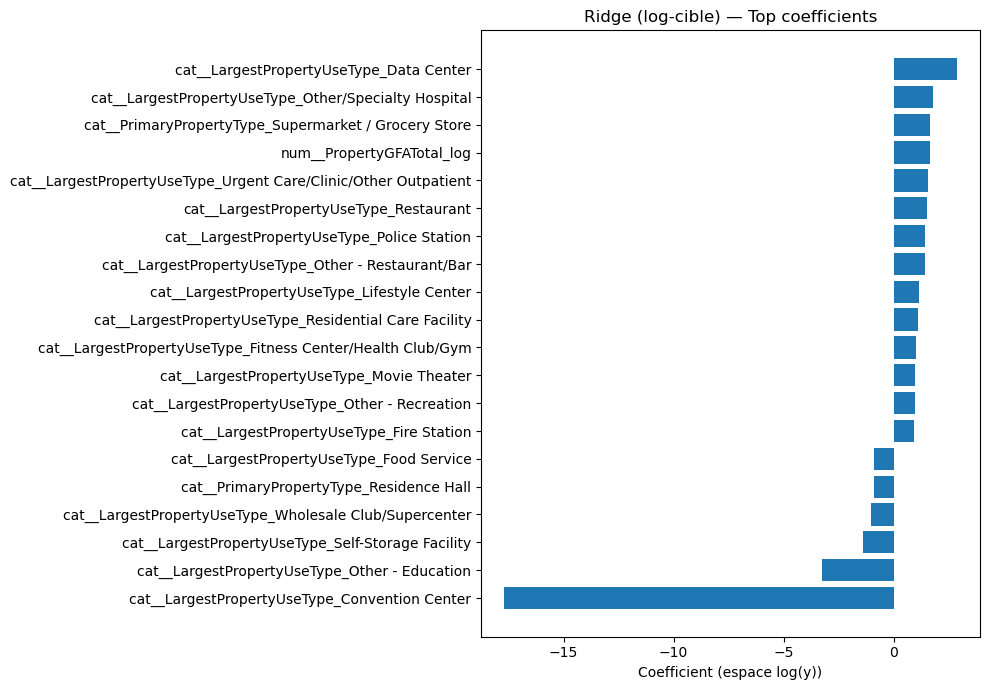

In [36]:
# --- Extraction des coefficients + noms de features post-preprocessing ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import Ridge

pipe = best_ridge_logy  # pipeline = ('prepro', ColumnTransformer), ('model', TransformedTargetRegressor(Ridge))

# 1) Récupérer le préprocesseur et le modèle interne
if "prepro" in pipe.named_steps:
    preprocessor = pipe.named_steps["prepro"]
else:
    # fallback : trouver un ColumnTransformer peu importe son nom
    preprocessor = None
    for name, step in pipe.named_steps.items():
        if isinstance(step, ColumnTransformer):
            preprocessor = step
            break
    if preprocessor is None:
        raise ValueError("Aucun ColumnTransformer trouvé dans le pipeline.")

model_step = pipe.named_steps["model"]
if isinstance(model_step, TransformedTargetRegressor):
    ridge_inner = model_step.regressor_
else:
    ridge_inner = model_step

if not isinstance(ridge_inner, Ridge):
    raise ValueError(f"Le modèle interne n'est pas un Ridge, mais {type(ridge_inner)}")

# 2) Coefficients appris
coefs = ridge_inner.coef_.ravel()
print("Nombre de coefficients:", len(coefs))

# 3) Noms de features APRES transformation (ils doivent matcher la longueur de coefs)
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    # Construction "manuelle" si sklearn < 1.0 ou si certains sous-steps ne supportent pas get_feature_names_out
    feature_names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "get_feature_names_out"):
            try:
                fn = trans.get_feature_names_out(cols)
            except TypeError:
                fn = trans.get_feature_names_out()
            feature_names.extend(fn)
        else:
            # Colonnes passées telles quelles
            if cols is None or cols == "drop":
                continue
            if isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
                feature_names.extend(list(cols))
            else:
                feature_names.append(str(cols))
    feature_names = np.array(feature_names)

print("Nombre de features (post-preproc):", len(feature_names))

if len(feature_names) != len(coefs):
    raise ValueError(
        f"Mismatch: {len(feature_names)} noms vs {len(coefs)} coefs. "
        "Utilise bien les noms post-preprocessing (ColumnTransformer)."
    )

# 4) Tableau des coefficients
coef_df = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
      .assign(abscoef=lambda d: d["coef"].abs())
      .sort_values("abscoef", ascending=False)
      .reset_index(drop=True)
)

display(coef_df.head(20))

# 5) Barplot des 20 plus influents (en valeur absolue)
top = 20
subset = coef_df.head(top).sort_values("coef")
plt.figure(figsize=(10, 7))
plt.barh(subset["feature"], subset["coef"])
plt.title("Ridge (log-cible) — Top coefficients")
plt.xlabel("Coefficient (espace log(y))")
plt.tight_layout()
plt.show()


En régression Ridge sur log(consommation), la surface (log) est la variable la plus déterminante. Certains usages sont nettement plus énergivores : Data Center (×14), Supermarket (×5), Restaurant/Clinique/Hôpital (×4–5). À l’inverse, Self-Storage consomme −67% vs la référence. Les coefficients extrêmes (ex. Convention Center) traduisent des modalités très rares ; nous regroupons ces catégories pour stabiliser le modèle.

# partie 2 test sur feature importance

In [37]:
print(feature_names[:100])

['num__PropertyGFATotal' 'num__PropertyGFABuilding(s)'
 'num__PropertyGFAParking' 'num__NumberofBuildings' 'num__NumberofFloors'
 'num__BuildingAge' 'num__CouncilDistrictCode' 'num__Latitude'
 'num__Longitude' 'num__ParkingRatio' 'num__PropertyGFATotal_log'
 'num__PropertyGFABuilding(s)_log' 'num__PropertyGFAParking_log'
 'num__BuildingDensity' 'num__GeoCluster'
 'cat__PrimaryPropertyType_Distribution Center'
 'cat__PrimaryPropertyType_Hospital' 'cat__PrimaryPropertyType_Hotel'
 'cat__PrimaryPropertyType_K-12 School'
 'cat__PrimaryPropertyType_Laboratory'
 'cat__PrimaryPropertyType_Large Office'
 'cat__PrimaryPropertyType_Low-Rise Multifamily'
 'cat__PrimaryPropertyType_Medical Office'
 'cat__PrimaryPropertyType_Mixed Use Property'
 'cat__PrimaryPropertyType_Other'
 'cat__PrimaryPropertyType_Refrigerated Warehouse'
 'cat__PrimaryPropertyType_Residence Hall'
 'cat__PrimaryPropertyType_Restaurant'
 'cat__PrimaryPropertyType_Retail Store'
 'cat__PrimaryPropertyType_Self-Storage Facility'


In [37]:
from pprint import pprint
pipe = best_ridge_logy  # ton pipeline final

print("Steps du pipeline :")
pprint(list(pipe.named_steps.keys()))

print("\nTypes des steps :")
for name, step in pipe.named_steps.items():
    print(f"- {name}: {type(step)}")


Steps du pipeline :
['prepro', 'model']

Types des steps :
- prepro: <class 'sklearn.compose._column_transformer.ColumnTransformer'>
- model: <class 'sklearn.compose._target.TransformedTargetRegressor'>


In [38]:
import numpy as np
import pandas as pd
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge

# --- 1) Récupérer le preprocessor et le modèle interne (Ridge) du pipeline ---
pipe = best_ridge_logy  # ton pipeline final

# adapte le nom du step si besoin: 'prep' / 'preprocess' / 'preprocessor'
if "prepro" in pipe.named_steps:
    preprocessor = pipe.named_steps["prepro"]
elif "preprocess" in pipe.named_steps:
    preprocessor = pipe.named_steps["preprocess"]
elif "preprocessor" in pipe.named_steps:
    preprocessor = pipe.named_steps["preprocessor"]
else:
    raise ValueError("Step de preprocessing introuvable (prep/preprocess/preprocessor).")

model_step = pipe.named_steps["model"]
assert isinstance(model_step, TransformedTargetRegressor)
ridge_model = model_step.regressor_
assert isinstance(ridge_model, Ridge)

# --- 2) Noms de features APRES transformation (alignés avec coef_) ---
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    # Fallback si sklearn ancien
    feature_names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "get_feature_names_out"):
            try:
                fn = trans.get_feature_names_out(cols)
            except TypeError:
                fn = trans.get_feature_names_out()
            feature_names.extend(fn)
        else:
            # colonnes passées telles quelles
            if isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
                feature_names.extend(list(cols))
            elif cols in ("drop", None):
                continue
            else:
                feature_names.append(str(cols))
    feature_names = np.array(feature_names)

# On force en np.array 1D pour une indexation positionnelle sûre
feature_names = np.asarray(feature_names)

# --- 3) Importances = |coefficients| (features standardisées ⇒ comparables) ---
coefs = ridge_model.coef_.ravel()
importances = np.abs(coefs)

# Sanity check
if len(importances) != len(feature_names):
    raise ValueError(f"Tailles incohérentes: importances={len(importances)} vs features={len(feature_names)}")

# --- 4) Fonction safe: retourne les features cumulant 'threshold' d'importance (normalisée) ---
def get_feature_most_importance(importances, feature_names, threshold=0.8):
    importances = np.asarray(importances, dtype=float).ravel()
    feature_names = np.asarray(feature_names)

    order = np.argsort(importances)[::-1]          # tri décroissant
    sorted_imps = importances[order]
    sorted_names = feature_names[order]

    total = sorted_imps.sum()
    if total <= 0:
        return sorted_names.tolist()

    cum = 0.0
    out = []
    for w, nm in zip(sorted_imps, sorted_names):
        cum += w / total                            # cumul normalisé (0–1)
        out.append(nm)
        if cum >= threshold:
            print(f"Importance cumulée atteinte: {cum:.3f}")
            break
    return out

important_features = get_feature_most_importance(importances, feature_names, threshold=0.8)
print("Top features cumulant 80% de l’influence :")
print(important_features[:20])  # affiche les 20 premières si la liste est longue



Importance cumulée atteinte: 0.802
Top features cumulant 80% de l’influence :
['cat__LargestPropertyUseType_Convention Center', 'cat__LargestPropertyUseType_Other - Education', 'cat__LargestPropertyUseType_Data Center', 'cat__LargestPropertyUseType_Other/Specialty Hospital', 'cat__PrimaryPropertyType_Supermarket / Grocery Store', 'num__PropertyGFATotal_log', 'cat__LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient', 'cat__LargestPropertyUseType_Restaurant', 'cat__LargestPropertyUseType_Police Station', 'cat__LargestPropertyUseType_Other - Restaurant/Bar', 'cat__LargestPropertyUseType_Self-Storage Facility', 'cat__LargestPropertyUseType_Lifestyle Center', 'cat__LargestPropertyUseType_Residential Care Facility', 'cat__LargestPropertyUseType_Wholesale Club/Supercenter', 'cat__LargestPropertyUseType_Fitness Center/Health Club/Gym', 'cat__LargestPropertyUseType_Movie Theater', 'cat__LargestPropertyUseType_Other - Recreation', 'cat__LargestPropertyUseType_Fire Station', 'cat__Primary